In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
from TS_datawindow import DataWindow

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
DATA_PATH = "C:/Users/campus3S031/Desktop/iMBank/iM_DiGital_Banker_academy/ML_TS/data/"

train_df = pd.read_csv(DATA_PATH + 'train.csv', index_col=0)
val_df = pd.read_csv(DATA_PATH + 'val.csv', index_col=0)
test_df = pd.read_csv(DATA_PATH + 'test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# 클래스는 같은 폴더 안에 있는 TS_datawindow.py

# 딥러닝 LSTM 모델 적용

In [6]:
def compile_and_fit (model, window, patience = 3, max_epochs = 50):
    early_stopping = EarlyStopping(monitor = 'val_loss', # 무엇을 볼 것인가?
                                   patience = patience,
                                   mode = 'min')
    
    model.compile(loss = MeanSquaredError(),
                  optimizer = Adam(),
                  metrics = [MeanAbsoluteError()])
    
    history = model.fit(window.train,
                        epochs = max_epochs,
                        validation_data = window.val,
                        callbacks = [early_stopping])
    
    return history

In [7]:
column_indices = {name: i for i , name in enumerate(train_df.columns)}
column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 단일 단계 LSTM 모델
- 24시간의 데이터 입력으로 사용 후 다음 시간 단계 예측
- 모델을 훈련할 데이터 윈도우 만들기
- 24시간의 데이터를 입력으로 사용하는 넓은 윈도우
- 도식화 위해 label_width도 24로 설정
- 예측값을 24개의 시간 단계에 걸쳐 실제값과 비교

In [9]:
single_step_window = DataWindow(input_width = 1, label_width = 1, shift = 1, label_columns = ['traffic_volume'])
wide_window = DataWindow(input_width = 24, label_width = 24, shift = 1, label_columns = ['traffic_volume'])

- 도식화를 위해 더 넓은 윈도우를 정의, 모델의 많은 예측 시각화
- 그렇지 않으면 하나의 입력 데이터 요소와 하나의 출력 예측만 시각화
- 즉 wide_window를 쓴다는 뜻이다.

# LSTM 모델 정의

In [10]:
# 미리 다른 모델을 돌려서 나온 결과라고 치자!!
# 각각 Baseline-Last, linear, Dense기반 모델이고, 여기에 LSTM을 추가할 생각각
mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [11]:
lstm_model = Sequential([
    LSTM(32, return_sequences = True),
    Dense(units = 1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose = 0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0521 - mean_absolute_error: 0.1673 - val_loss: 0.0118 - val_mean_absolute_error: 0.0807
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0706 - val_loss: 0.0053 - val_mean_absolute_error: 0.0527
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0055 - mean_absolute_error: 0.0532 - val_loss: 0.0042 - val_mean_absolute_error: 0.0478
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0045 - mean_absolute_error: 0.0478 - val_loss: 0.0033 - val_mean_absolute_error: 0.0415
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0413 - val_loss: 0.0029 - val_mean_absolute_error: 0.0374
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0384 - val_loss: 0.0026 - val_mean_absolute_error: 0.0349
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0365 - v

# Model Visualization

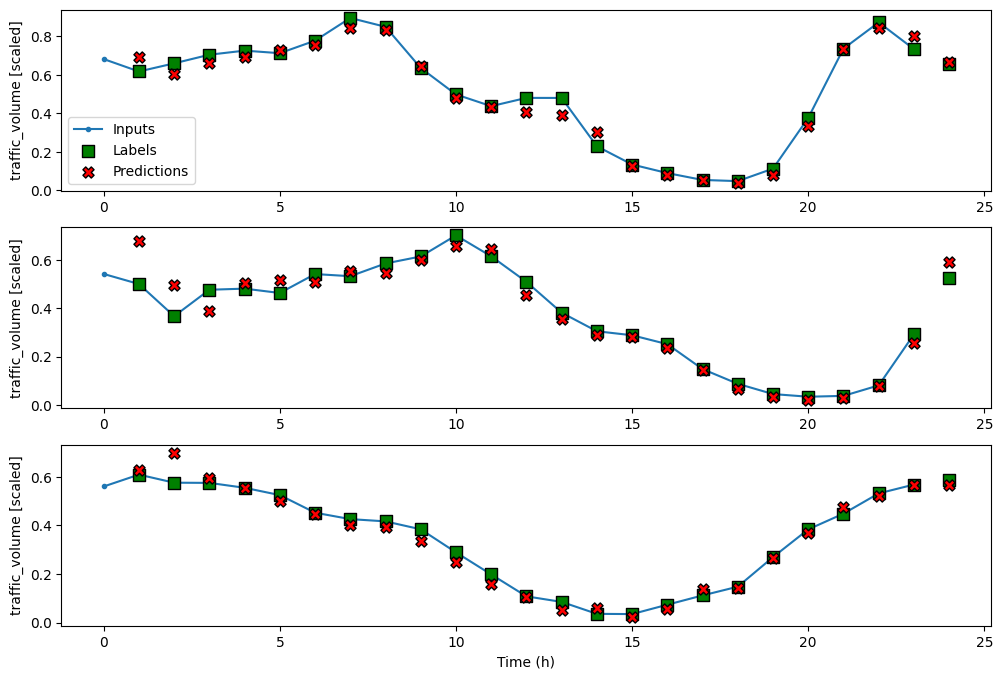

In [12]:
wide_window.plot(lstm_model)

# 평가지표 비교

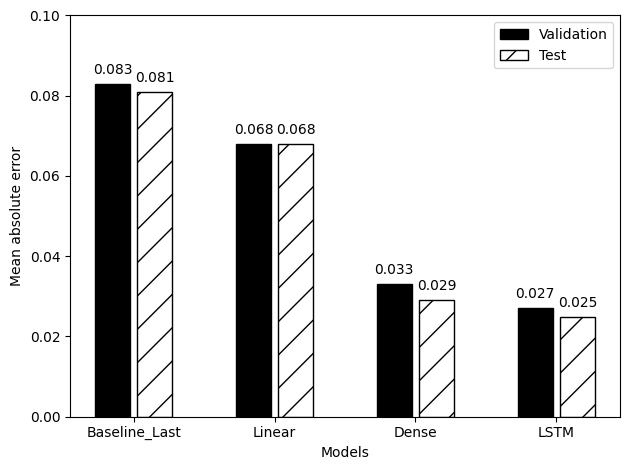

In [13]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ["Baseline_Last", 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width = 0.25, color = 'black', edgecolor = 'black', label = 'Validation')
ax.bar(x + 0.15, mae_test, width = 0.25, color = 'white', edgecolor = 'black', hatch = '/', label = 'Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x = index-0.15, y = value + 0.0025, s = str(round(value, 3)), ha = 'center')
for index, value in enumerate(mae_test):
    plt.text(x = index+0.15, y = value + 0.0025, s = str(round(value, 3)), ha = 'center')

plt.ylim(0, 0.1)
plt.xticks(ticks = x, labels = labels)
plt.legend(loc = 'best')
plt.tight_layout()

plt.show()

# 다중 단계 LSTM 모델
- 24시간의 입력 윈도우를 사용하여 향후 24시간 동안의 교통량 예측
- 모델에 입력할 시간 윈도우 정의

In [14]:
# wide_window와 비교하면 shift(모델이 움직이는 거리)가 1에서 24로 한 단위로 늘었다.
multi_window = DataWindow(input_width = 24, label_width = 24, shift = 24, label_columns = ['traffic_volume'])

## LSTM 모델 정의

In [15]:
# 기존 윈도잉 모델에서 가져옴 (비교 위해)
ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [16]:
# 단일모델과 비교해 Dense에 이니셜라이저가 추가되었다.

ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 1, kernel_initializer= tf.initializers.zeros)
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose = 0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0958 - mean_absolute_error: 0.2366 - val_loss: 0.0214 - val_mean_absolute_error: 0.1040
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0179 - mean_absolute_error: 0.0940 - val_loss: 0.0178 - val_mean_absolute_error: 0.0932
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0152 - mean_absolute_error: 0.0837 - val_loss: 0.0164 - val_mean_absolute_error: 0.0836
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0144 - mean_absolute_error: 0.0801 - val_loss: 0.0158 - val_mean_absolute_error: 0.0827
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0139 - mean_absolute_error: 0.0780 - val_loss: 0.0154 - val_mean_absolute_error: 0.0816
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0136 - mean_absolute_error: 0.0769 - val_loss: 0.0157 - val_mean_absolute_error: 0.0857
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0134 - mean_absolute_error: 0.0

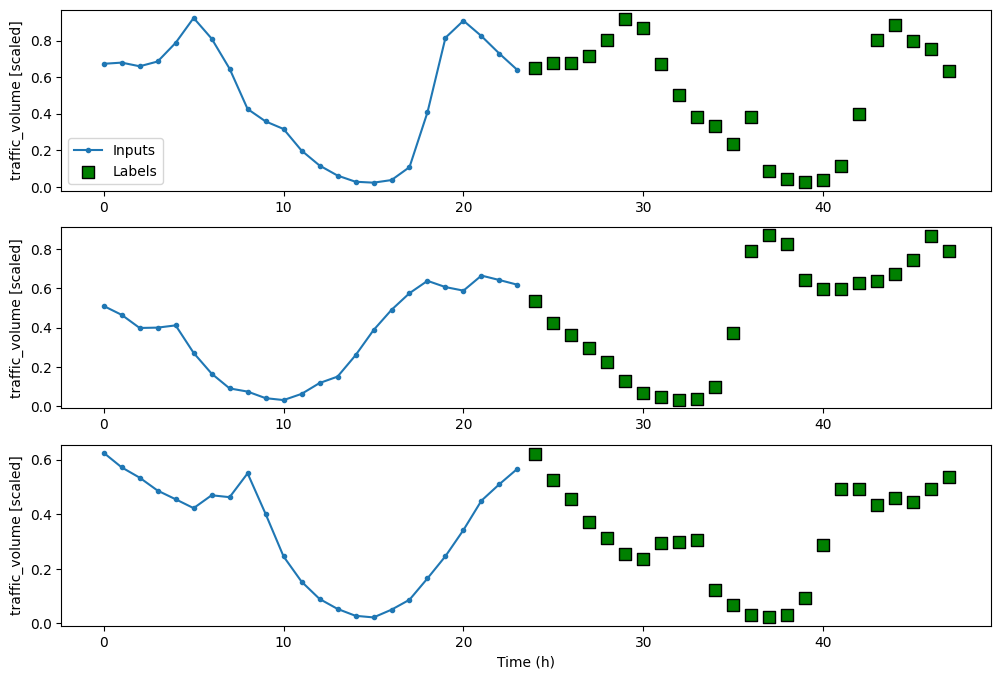

In [17]:
multi_window.plot()

## 평가지표 비교

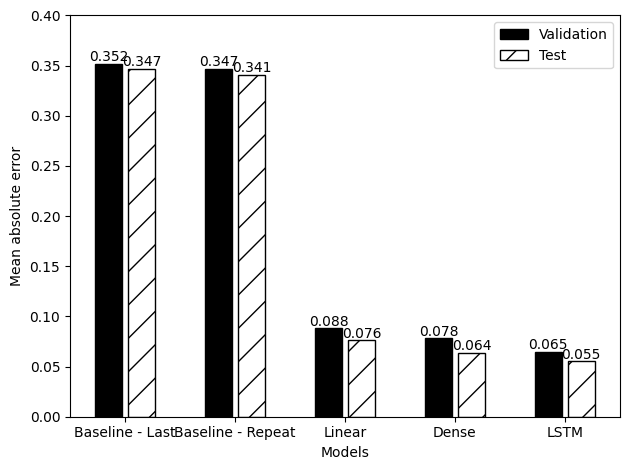

In [18]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width = 0.25, color = 'black', edgecolor = 'black', label = 'Validation')
ax.bar(x + 0.15, ms_mae_test, width = 0.25, color = 'white', edgecolor = 'black', hatch = '/', label = 'Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x = index - 0.15, y = value + 0.0025, s = str(round(value, 3)), ha = 'center')

for index, value in enumerate(ms_mae_test):
    plt.text(x = index + 0.15, y = value + 0.0025, s = str(round(value, 3)), ha = 'center')

plt.ylim(0, 0.4)
plt.xticks(ticks = x, labels = labels)
plt.legend(loc = 'best')
plt.tight_layout()

plt.show()

# 다중 출력 LSTM 모델
- 24시간의 입력 데이터 사용하여 네트워크가 일련의 데이터 요소 처리
- 과거 정보를 사용하여 예측 생성
- 예측은 다음 시간 단계의 교통량과 온도 모두에 대한 것

In [19]:
# SIngle, Multi_Select 모델이랑 비교해보면서 코드 읽을 것.
# 전체적으로 Single과 Multi_select를 섞은 듯한 느낌이 난다. 
mo_single_step_window = DataWindow(input_width = 1, label_width = 1,shift = 1, label_columns = ['temp', 'traffic_volume'])
mo_wide_window = DataWindow(input_width = 24, label_width = 24, shift = 1, label_columns = ['temp', 'traffic_volume'])

In [20]:
mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [21]:
# Multi-Out 모델은 2가지로 예측하므로 Dense에서 출력되는 값도 2가지,
# 따라서 units 파라미터도 2로 설정해 주어야 한다.

mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose = 0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0744 - mean_absolute_error: 0.1942 - val_loss: 0.0113 - val_mean_absolute_error: 0.0681
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0080 - mean_absolute_error: 0.0584 - val_loss: 0.0044 - val_mean_absolute_error: 0.0429
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0040 - mean_absolute_error: 0.0412 - val_loss: 0.0030 - val_mean_absolute_error: 0.0360
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0032 - mean_absolute_error: 0.0365 - val_loss: 0.0026 - val_mean_absolute_error: 0.0337
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0336 - val_loss: 0.0022 - val_mean_absolute_error: 0.0305
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0315 - val_loss: 0.0020 - val_mean_absolute_error: 0.0288
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0301 

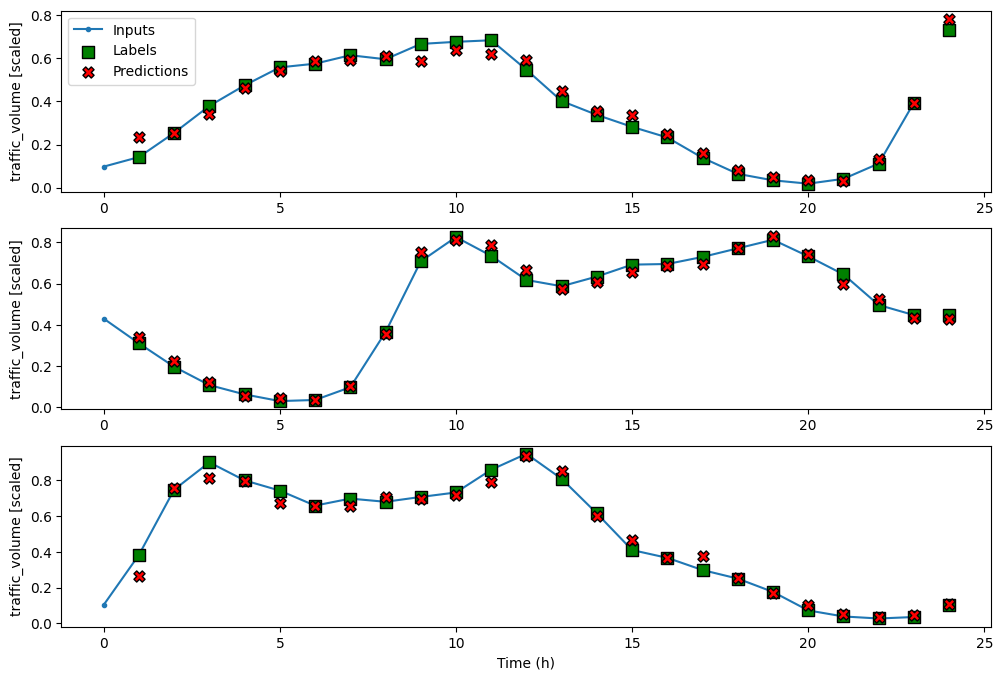

In [22]:
mo_wide_window.plot(mo_lstm_model)

## 평가지표 비교

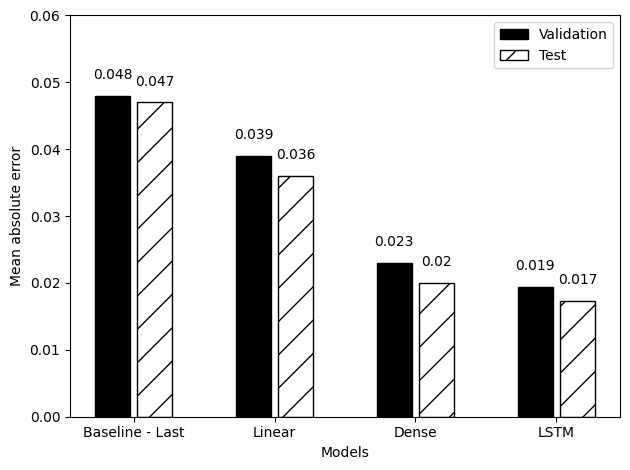

In [23]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.show()